# XGBoost Regression

In [21]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [22]:
df = pd.read_csv('FE_data_18-19.csv', index_col=0)

# sort by date
df.sort_values(by='Date', inplace=True)

# make date the index
df.set_index('Date',inplace=True)

#### Ordered Test Set

In [208]:
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

#### Random Test Set

In [211]:
X = df.drop(labels=['SsMean','logSsMean'], axis=1)
y = df.logSsMean

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [212]:
# encode location
le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

kbest = SelectKBest(k=20)
kbest = kbest.fit(X_train,y_train)
X_train = kbest.transform(X_train)
X_test = kbest.transform(X_test)

xg = xgb.XGBRegressor(gamma=2, learning_rate=0.05, n_estimators=300)
xg.fit(X_train,y_train)

<ipython-input-212-2af081944ac3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Location'] = le.transform(X_train['Location'])
<ipython-input-212-2af081944ac3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Location'] = le.transform(X_test['Location'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Training acc: 0.8876410792922917
Testing acc: 0.2330197638587267
Train Mean squared error:  0.36847500359010243
Test Mean squared error:  2.7061292143609483
Train MAE:  0.48256919125557357
Test MAE:  1.2013509223741978


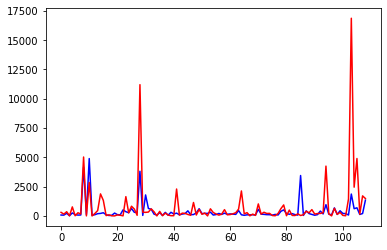

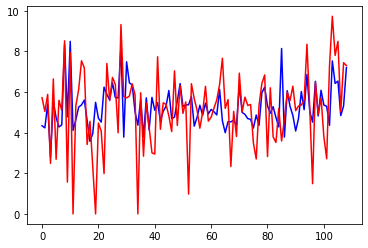

In [213]:
y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

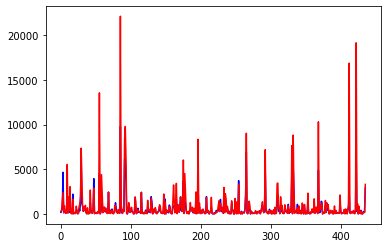

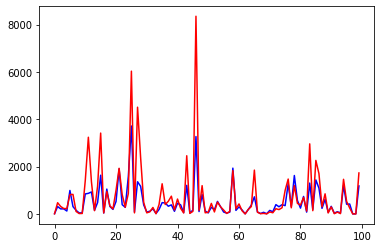

In [214]:
# plot training
plt.plot(np.exp(train_pred), c='b')
plt.plot(np.exp(y_train.values), c='r')
plt.show()

# close up
plt.plot(np.exp(train_pred)[150:250], c='b')
plt.plot(np.exp(y_train.values)[150:250], c='r')
plt.show()

### Cross val grid search

In [57]:
from sklearn.model_selection import GridSearchCV

params = {
    'eta': [0.3,0.1, 0.05],
    'max_depth': [3, 2, 1],
    'min_child_weight': [0,1,2],
    'gamma': [0, 1, 2],
    'lambda': [0, 1, 2, 3],
    'n_estimators': [100, 200]
}

kfolds = 5

clf = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=params, cv=kfolds)

#### Ordered Test Set

In [ ]:
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

#### Random Test Set

In [58]:
X = df.drop(labels=['SsMean','logSsMean'], axis=1)
y = df.logSsMean

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [59]:
# encode location
le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<ipython-input-59-ca021516fd28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Location'] = le.transform(X_train['Location'])
<ipython-input-59-ca021516fd28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Location'] = le.transform(X_test['Location'])


In [60]:
clf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [61]:
best_parameters = clf.best_params_
print(best_parameters)

{'eta': 0.05, 'gamma': 0, 'lambda': 0, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100}


In [62]:
best_result = clf.best_score_
print(best_result)

0.3340662142529257


Training acc: 0.5628147615790842
Testing acc: 0.21931901794919606
Train Mean squared error:  1.433725344476678
Test Mean squared error:  2.754469428381128
Train MAE:  0.9361402194152884
Test MAE:  1.2000199536621015


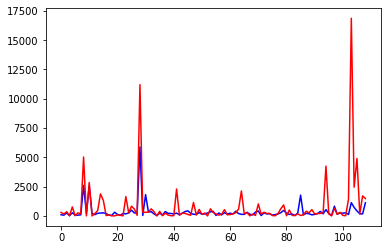

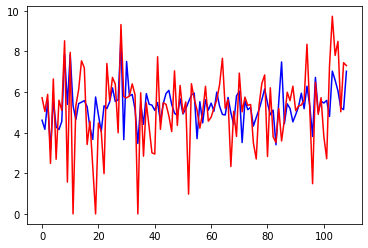

In [63]:
xg = clf.best_estimator_

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()